*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/advb_article/1_sample_makeup.ipynb)*

# Time Adverbial Distribution and Collocations
## Sample Makeup
### Cody Kingham
<a href="../../../docs/sponsors.md"><img height=200px width=200px align="left" src="../../../docs/images/CambridgeU_BW.png"></a>

In [1]:
! echo "last updated:"; date

last updated:
Sat 13 Jun 2020 13:10:04 BST


## Introduction

In this notebook we'll examine the composition of the phrase sample.

<hr>

# Python

Now we import the modules and data needed for the analysis.

In [2]:
from config import *

<hr>

# Rough Dataset for All Phrase Functions

`functs_df` contains precision data for the functions `{'Time', 'Subj', 'Objc', 'Loca', 'Adju', 'Cmpl'}`.<br>
But this data represents just a subset of all phrases in the Hebrew Bible.

objective: produce and analyze data on the subset of samples to test for representation and dispersion.<br>
How representative can the subset be for each function?

In [3]:
phrase_dataset = []

for phrase in F.otype.s('phrase'):
    
    # exclude Aramaic portions
    lang = F.language.v(L.d(phrase,'word')[0])
    if lang != 'Hebrew':
        continue
    
    book, chapter, verse = T.sectionFromNode(phrase)
    book_sbl = form.book2sbl[book]
    sentence = L.u(phrase, 'sentence')[0]
    ref = f'{form.book2sbl[book]} {chapter}:{verse}'
    function = F.function.v(phrase)
    s_function = form.simplified_functions.get(function, function)
    n_words = len(L.d(phrase, 'word'))
    n_phrase_atoms = len(L.d(phrase, 'phrase_atom'))
    heads = E.nhead.t(phrase)
    n_heads = len(heads)
    first_head = heads[0]
    head_lexs = '|'.join(F.lex.v(h) for h in heads)
    head_utf8 = '|'.join(T.text(h).strip() for h in heads)
    head_lexnodes = tuple(L.u(h,'lex')[0] for h in heads)
    daughters = E.mother.t(phrase)
    n_daughters = len(daughters)
    mothers = E.mother.f(phrase)
    n_mothers = len(mothers)
    d_relas = '|'.join(F.rela.v(d) for d in daughters)
    ph_typ = F.typ.v(phrase)
    rela = F.rela.v(phrase)
    time_phrase = L.u(phrase, 'timephrase')
    parsed = phrase in functs_df.index
    parsed = 1 if parsed else 0
    
    phrase_dataset.append({
        'node': phrase,
        'ref': ref,
        'book': book_sbl,
        'text': T.text(phrase),
        'sentence': T.text(sentence),
        'type': ph_typ,
        'function': function,
        's_function': s_function,
        'rela': rela,
        'n_words': n_words,
        'n_phrase_atoms': n_phrase_atoms,
        'n_heads': n_heads,
        'head_lex': head_lexs,
        'head_lex_nodes': head_lexnodes,
        'n_daughters': n_daughters,
        'daught_relas': d_relas or np.nan,
        'n_mothers': n_mothers,
        'n_relas': n_daughters + n_mothers,
        'in_timephrase': bool(time_phrase),
        'parsed': parsed,
    })
    
print(len(phrase_dataset), 'phrases collected...')

249382 phrases collected...


In [4]:
phrase_df = pd.DataFrame(phrase_dataset)
phrase_df.set_index('node', inplace=True)

In [5]:
phrase_df.head()

,ref,book,text,sentence,type,function,s_function,rela,n_words,n_phrase_atoms,n_heads,head_lex,head_lex_nodes,n_daughters,daught_relas,n_mothers,n_relas,in_timephrase,parsed
node,,,,,,,,,,,,,,,,,,,
651542,Gen 1:1,Gen,בְּרֵאשִׁ֖ית,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,PP,Time,Time,NA,2,1,1,R>CJT/,"(1437568,)",0,NaN,0,0,True,1
651543,Gen 1:1,Gen,בָּרָ֣א,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,VP,Pred,Pred,NA,1,1,1,BR>[,"(1437569,)",0,NaN,0,0,False,0
651544,Gen 1:1,Gen,אֱלֹהִ֑ים,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,NP,Subj,Subj,NA,1,1,1,>LHJM/,"(1437570,)",0,NaN,0,0,False,1
651545,Gen 1:1,Gen,אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,PP,Objc,Objc,NA,7,1,2,CMJM/|>RY/,"(1437573, 1437575)",0,NaN,0,0,False,0
651546,Gen 1:2,Gen,וְ,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ,CP,Conj,Conj,NA,1,1,1,W,"(1437574,)",0,NaN,0,0,False,0


## Examine effects of each selection for sample across selection criteria

In [6]:
# we build a series of pivot tables and proportion data calculated
# from the tables; to configure each table, we load valeus into a dictionary

# store settings to build all tables
table_settings = {
    'n_atoms': {                          # name of table
        'cols': ['n_phrase_atoms'],       # name of cols to cross tabulate with function
        'sum_column': 1,                  # name or list of cols to sum versus others
        'new_cols': ('na = 1', 'na > 1'), # label for new columns
    },
    'n_heads': {
        'cols': ['n_heads'],
        'sum_column': 1,
        'new_cols': ('nh = 1', 'nh > 1')
    },
    'n_relas': {
        'cols': ['n_relas'],
        'sum_column': 0,
        'new_cols': ('nr = 0', 'nr > 0'),
    },
    'n_parsed': {
        'cols': ['parsed'],
        'sum_column': 1,
        'new_cols': ('y', 'n')
    },
#     'n_all': {
#         'cols': ['n_phrase_atoms', 'n_heads', 'n_relas', 'parsed'],
#         'sum_column': (1, 1, 0, 1),
#         'new_cols': ('sample', 'others'),
#     }
}

# define sample
functions_sample = sorted([
    'Adju',
    'Cmpl',
    'Loca',
    'Objc',
    'Subj',
    'Time',
])
funct_sample = phrase_df[phrase_df.s_function.isin(functions_sample)]

pivots = {}
for name, setting in table_settings.items():
    
    # build pivot tables that count all of the set columns
    # as they appear together
    pivots[name] = pd.pivot_table(
        funct_sample, 
        index='s_function',
        columns=setting['cols'],
        aggfunc='size',
        fill_value=0,
    )

    
# make summaries 
sums = {}
for name, setting in table_settings.items():
    pivot = pivots[name]
    first_sum = pivot[setting['sum_column']]
    second_sum = pivot.drop(columns=setting['sum_column']).sum(1)    
    new_table = pd.concat([first_sum, second_sum], 1)
    new_table.columns = setting['new_cols']
    sums[name] = new_table
    
    
props = {}
for name, table in sums.items():
    props[name] = table.div(table.sum(1), 0)
    
props.keys()

dict_keys(['n_atoms', 'n_heads', 'n_relas', 'n_parsed'])

Make the subplots.

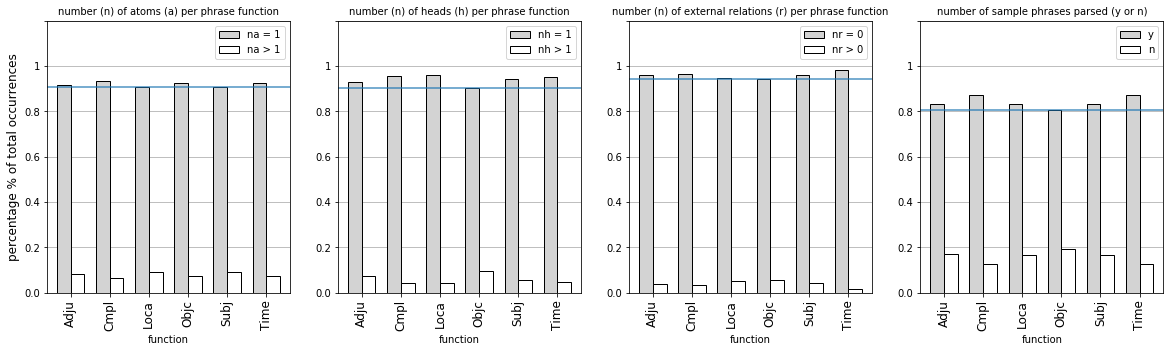

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

props['n_atoms'].plot(kind='bar', ax=ax1, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax1.axhline(props['n_atoms']['na = 1'].min(), alpha=0.8)
ax1.set_title('number (n) of atoms (a) per phrase function', size=10)

props['n_heads'].plot(kind='bar', ax=ax2, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax2.axhline(props['n_heads']['nh = 1'].min(), alpha=0.8)
ax2.set_title('number (n) of heads (h) per phrase function', size=10)

props['n_relas'].plot(kind='bar', ax=ax3, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax3.axhline(props['n_relas']['nr = 0'].min(), alpha=0.8)
ax3.set_title('number (n) of external relations (r) per phrase function', size=10)

props['n_parsed'].plot(kind='bar', ax=ax4, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax4.axhline(props['n_parsed']['y'].min(), alpha=0.8)
ax4.set_title('number of sample phrases parsed (y or n)', size=10)

# props['n_all'].plot(kind='bar', ax=ax5, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
# ax5.axhline(props['n_all']['sample'].min(), alpha=0.8)
# ax5.set_title('number of sampled versus excluded phrases', size=10)

axes = (ax1, ax2, ax3, ax4)

ax1.set_ylabel('percentage % of total occurrences', size=12)

for ax, data in zip(axes, props):
    
    ax.set_ylim(0, 1.2)
    ax.grid(axis='y')
    ax.set_axisbelow(True) 
    ax.set_xlabel('function', size=10)
    ax.set_xticklabels(ax.get_xticklabels(), size=12)
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1])
    
savefig('funct_sample')

In [8]:
props['n_parsed'].T.sort_values(by='y', axis=1)

s_function,Objc,Adju,Subj,Loca,Cmpl,Time
y,0.806913,0.831029,0.832893,0.834167,0.873647,0.874726
n,0.193087,0.168971,0.167107,0.165833,0.126353,0.125274


In [9]:
props['n_parsed']['y'].mean()

0.8422291582028945

In [10]:
sums['n_parsed']

,y,n
s_function,,
Adju,7815,1589
Cmpl,25832,3736
Loca,2168,431
Objc,18070,4324
Subj,26172,5251
Time,3987,571


In [11]:
#pd.DataFrame(sums['n_parsed']['y']).T.to_clipboard()

In [12]:
# total sample size
sums['n_parsed'].sum()

y    84044
n    15902
dtype: int64